## On the importance of custom metrics. 

In [2]:
import pandas as pd

# Load the CSV (if starting from file)
german_credit = pd.read_csv("datasets/statlog_german_credit.csv")

# Separate features and target
X = german_credit.drop(columns=["target"])
y = german_credit["target"]

In [3]:
X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


In [ ]:
%pip install skrub

from skrub import TableVectorizer
from collections import Counter

Counter(list(y[:, 0]))

Counter({np.int64(1): 700, np.int64(2): 300})

In [5]:
pos_label, neg_label = 1, 2

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [7]:
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, confusion_matrix
import numpy as np


def business_metric(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    gain_matrix = np.array(
        [
            [0, -1],  # gain for false positives
            [-2, 0],  # gain for false negatives
        ]
    )
    return np.sum(cm * gain_matrix)

scoring = {
    "precision": make_scorer(precision_score, pos_label=pos_label),
    "recall": make_scorer(recall_score, pos_label=pos_label),
    "accuracy": make_scorer(accuracy_score),
    "business_metric": make_scorer(business_metric, pos_label=pos_label, neg_label=neg_label),
}

In [8]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(
    TableVectorizer(),
    HistGradientBoostingClassifier(categorical_features="from_dtype", random_state=0)
)

cv = GridSearchCV(pipe, scoring=scoring, param_grid={"histgradientboostingclassifier__learning_rate": [0.01, 0.05, 0.1]}, refit=False, n_jobs=-1)
cv.fit(X_train, y_train.ravel())

GridSearchCV(estimator=Pipeline(steps=[('tablevectorizer', TableVectorizer()),
                                       ('histgradientboostingclassifier',
                                        HistGradientBoostingClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'histgradientboostingclassifier__learning_rate': [0.01,
                                                                           0.05,
                                                                           0.1]},
             refit=False,
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'business_metric': make_scorer(business_metric, response_method='predict', pos_label=1, neg_label=2),
                      'precision': make_scorer(precision_score, response_method='predict', pos_label=1),
                      'recall': make_scorer(recall_score, response_method='predict', pos_label=1)})

In [ ]:
%pip install polars

import polars as pl 

pl.DataFrame({k: v 
              for k, v in cv.cv_results_.items() 
              if ("mean_test" in k) or ("learning" in k)})

param_histgradientboostingclassifier__learning_rate,mean_test_precision,mean_test_recall,mean_test_accuracy,mean_test_business_metric
f64,f64,f64,f64,f64
0.01,0.739698,0.95619,0.733333,-44.6
0.05,0.797415,0.895238,0.765333,-46.2
0.1,0.797564,0.889524,0.764,-47.0


## Automating towards a good threshold value. 

In [9]:
from sklearn.model_selection import TunedThresholdClassifierCV

tuned_model = TunedThresholdClassifierCV(
    estimator=pipe,
    scoring=scoring["business_metric"],
    store_cv_results=True,  # necessary to inspect all results
    thresholds=200, 
    n_jobs=-1
)
tuned_model.fit(X_train, y_train.ravel())

print(f"{tuned_model.best_threshold_=:0.2f}")

tuned_model.best_threshold_=0.11


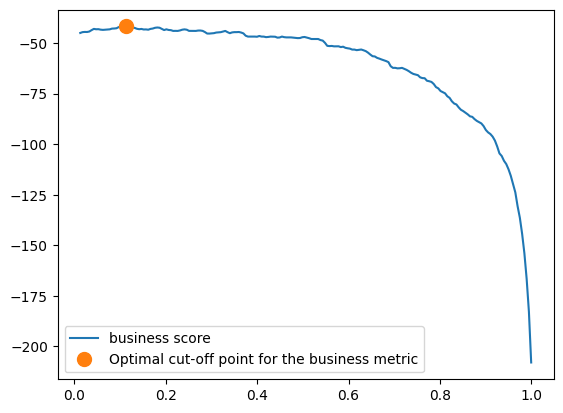

In [10]:
import matplotlib.pylab as plt

plt.plot(
    tuned_model.cv_results_["thresholds"], 
    tuned_model.cv_results_["scores"],
    label="business score"
)
plt.plot(
    tuned_model.best_threshold_,
    tuned_model.best_score_,
    "o",
    markersize=10,
    color="tab:orange",
    label="Optimal cut-off point for the business metric",
)
plt.legend()

In [11]:
from sklearn.model_selection import TunedThresholdClassifierCV

tuned_model = TunedThresholdClassifierCV(
    estimator=pipe,
    scoring=scoring["accuracy"],
    store_cv_results=True,  # necessary to inspect all results
    thresholds=200, 
    n_jobs=-1
)
tuned_model.fit(X_train, y_train.ravel())

print(f"{tuned_model.best_threshold_=:0.2f}")

tuned_model.best_threshold_=0.50


Just one notices on training times, it is totally retraining internally now and we might not want that. If we already have a classifier with properties that we like then we can also do this:

In [12]:
%%time

tuned_model = TunedThresholdClassifierCV(
    estimator=pipe,
    scoring=scoring["accuracy"],
    store_cv_results=True,  # necessary to inspect all results
    thresholds=200, 
    n_jobs=-1
)
tuned_model.fit(X_train, y_train.ravel())

CPU times: user 3 s, sys: 1.62 s, total: 4.62 s
Wall time: 1.01 s


TunedThresholdClassifierCV(estimator=Pipeline(steps=[('tablevectorizer',
                                                      TableVectorizer()),
                                                     ('histgradientboostingclassifier',
                                                      HistGradientBoostingClassifier(random_state=0))]),
                           n_jobs=-1,
                           scoring=make_scorer(accuracy_score, response_method='predict'),
                           store_cv_results=True, thresholds=200)

In [13]:
pipe.fit(X_train, y_train.ravel())

Pipeline(steps=[('tablevectorizer', TableVectorizer()),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(random_state=0))])

In [14]:
%%time 

tuned_model = TunedThresholdClassifierCV(
    estimator=pipe,
    scoring=scoring["accuracy"],
    store_cv_results=True,  # necessary to inspect all results
    thresholds=200, 
    n_jobs=-1, 
    cv="prefit", 
    refit=False
)
tuned_model.fit(X_train, y_train.ravel())

CPU times: user 212 ms, sys: 197 ms, total: 409 ms
Wall time: 87.1 ms


TunedThresholdClassifierCV(cv='prefit',
                           estimator=Pipeline(steps=[('tablevectorizer',
                                                      TableVectorizer()),
                                                     ('histgradientboostingclassifier',
                                                      HistGradientBoostingClassifier(random_state=0))]),
                           n_jobs=-1, refit=False,
                           scoring=make_scorer(accuracy_score, response_method='predict'),
                           store_cv_results=True, thresholds=200)

## Metadata routing

In [15]:
import polars as pl

df = pl.read_parquet("/Users/vincent/Downloads/credit_card.parquet")

In [16]:
target_name = "Class"
X = df.drop(target_name, "Time")
y = np.array(df[target_name]).astype(int)

In [18]:
from collections import Counter

Counter(y)

Counter({np.int64(0): 284315, np.int64(1): 492})

In [19]:
commission_transaction_gain = 0.02
avg_accept_fraud_cost = 20
avg_refuse_legit_cost = 10


def business_gain_func(y_true, y_pred, amount):
    true_negative = (y_pred == 0) & (y_true == 0)
    false_negative = (y_pred == 0) & (y_true == 1)
    false_positive = (y_pred == 1) & (y_true == 0)
    true_positive = (y_pred == 1) & (y_true == 1)

    accept_legitimate = (amount[true_negative] * commission_transaction_gain).sum()
    accept_fraudulent = -(amount[false_negative].sum() + (false_negative * avg_accept_fraud_cost).sum())
    refuse_legitimate = -(false_positive * avg_refuse_legit_cost).sum()

    return accept_legitimate + accept_fraudulent + refuse_legitimate

This function is a bit different. Before, we had inputs to metric functions that we could handle via `make_scorer(**kwargs)`. But in that case we were talking about settings that remain constant. In this case we are talking about metrics that depend on *each row of data*. 

This requires a new mechanism. This requires *metadata routing*. 

In [20]:
import sklearn
from sklearn.metrics import make_scorer

sklearn.set_config(enable_metadata_routing=True)
business_gain_scorer = make_scorer(business_gain_func).set_score_request(amount=True)

In [21]:
amount = df["Amount"].to_numpy()

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

logistic_regression = make_pipeline(StandardScaler(), LogisticRegression())
cross_val_score(logistic_regression, X, y, params={"amount": amount}, scoring=business_gain_scorer, n_jobs=-1)

array([104976.3806, 102597.1226,  70384.8732, 106722.6996,  79811.4474])

But metadata routing can also go a step further, it can be used to train pipelines too!

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, amount_train, amount_test = (
    train_test_split(
        X, y, amount, stratify=y, test_size=0.5, random_state=42
    )
)

In [27]:
%%time 

est = LogisticRegression(max_iter=1000, random_state=42)
est.fit(X_train, y_train)
est.coef_

CPU times: user 4min 57s, sys: 1min 57s, total: 6min 54s
Wall time: 1min


array([[ 3.83551636e-02,  6.72381015e-02,  6.69676662e-02,
         7.83537972e-01,  9.64949101e-02, -8.86135831e-02,
        -9.16427968e-02, -1.41497374e-01, -2.10440164e-01,
        -7.68215982e-01, -4.33703505e-02,  4.13340407e-01,
        -5.80211848e-01, -7.44295885e-01,  1.66810441e-01,
        -1.77173248e-01, -1.47962454e-01, -8.23329135e-02,
        -4.92160853e-02, -3.44623840e-01,  3.85002627e-01,
         5.97126215e-01, -8.81253492e-02,  1.36031587e-01,
        -1.29779034e-01,  3.08374321e-01, -5.87771300e-01,
        -5.08485529e-02,  7.80922086e-04]])

In [28]:
%%time

est = LogisticRegression(max_iter=1000, random_state=42).set_fit_request(sample_weight=True)
est.fit(X_train, y_train, sample_weight=amount_train)
est.coef_

CPU times: user 8min 59s, sys: 3min 25s, total: 12min 24s
Wall time: 1min 49s


/Users/vincent/Development/probabl/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[ 4.55597782e-01,  6.15117556e-01, -1.69138024e-01,
         1.36792325e+00,  6.72883038e-01, -3.53915527e-01,
         1.14568539e-01,  5.04143788e-02, -2.83272276e-01,
        -1.88105604e+00, -8.81585822e-01,  1.68660716e+00,
        -1.40636852e+00, -1.00989264e+00,  8.00177047e-01,
        -2.32206012e-01, -7.30742336e-01, -3.55935321e-01,
         3.84263162e-01, -5.32863637e-01,  2.48016281e-01,
         5.66986984e-01,  9.68835474e-02,  8.61026383e-01,
         2.82017698e-04, -4.12431565e-01, -1.39573989e+00,
        -1.17690400e+00,  3.27222944e-03]])

There is a subtle difference in the coefficients here (as well as a convergence warning). This is because we are using a sample weight that depends on the size of the transaction. 

That said, we can get even more elaborate by combining the two. 

In [29]:
from sklearn.model_selection import RandomizedSearchCV

In [30]:
cv = RandomizedSearchCV(
    est, 
    param_distributions={"C": np.logspace(-3, -1, 100)}, 
    n_jobs=-1, 
    n_iter=8, 
    scoring=business_gain_scorer
)

In [31]:
cv.fit(X_train, y_train, sample_weight=amount_train, amount=amount_train)

/Users/vincent/Development/probabl/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vincent/Development/probabl/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

RandomizedSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_iter=8, n_jobs=-1,
                   param_distributions={'C': array([0.001     , 0.00104762, 0.0010975 , 0.00114976, 0.0012045 ,
       0.00126186, 0.00132194, 0.00138489, 0.00145083, 0.00151991,
       0.00159228, 0.0016681 , 0.00174753, 0.00183074, 0.00191791,
       0.00200923, 0.0021049 , 0.00220513, 0.00231013, 0.00242013,
       0.0025353...
       0.02595024, 0.02718588, 0.02848036, 0.02983647, 0.03125716,
       0.03274549, 0.03430469, 0.03593814, 0.03764936, 0.03944206,
       0.04132012, 0.04328761, 0.04534879, 0.0475081 , 0.04977024,
       0.05214008, 0.05462277, 0.05722368, 0.05994843, 0.06280291,
       0.06579332, 0.06892612, 0.07220809, 0.07564633, 0.07924829,
       0.08302176, 0.0869749 , 0.09111628, 0.09545485, 0.1       ])},
                   scoring=make_scorer(business_gain_func, response_method='predict'))

This is kind of the dream of metadata routing. You can route metadata specifically to the components that need it. 

- You can pass it to some transfromers, but maybe not to the predictive estimator.
- You can pass it to only a scorer, but also do a scorer and an estimator.
- You can really "wiggle business logic" into these pipelines in a bespoke manner.

## Variable Decision Thresholds

This video might show off the coolest scikit-learn party trick that I know, partially because it *really* combines all sorts of advanced features into a principled and well interpretable pipeline. 

In [62]:
commission_transaction_gain = 0.05
avg_accept_fraud_cost = 20
avg_refuse_legit_cost = 10


def business_gain_func(y_true, y_pred, amount):
    true_negative = (y_pred == 0) & (y_true == 0)
    false_negative = (y_pred == 0) & (y_true == 1)
    false_positive = (y_pred == 1) & (y_true == 0)
    true_positive = (y_pred == 1) & (y_true == 1)

    accept_legitimate = (amount[true_negative] * commission_transaction_gain).sum()
    accept_fraudulent = -(amount[false_negative].sum() + (false_negative * avg_accept_fraud_cost).sum())
    refuse_legitimate = -(false_positive * avg_refuse_legit_cost).sum()

    return accept_legitimate + accept_fraudulent + refuse_legitimate

With the help of a little math, we can figure out the probability threshold given the costs of making a decision!

In [55]:
import sympy as sp

ctn, cfp, cfn, ctp = sp.symbols('c(tn), c(fp), c(fn), c(tp)')
p = sp.symbols("p")

cost_positive = p * ctp + (1-p) * cfp
cost_negative = (1-p) * ctn + p * cfn

sp.Eq(cost_positive, cost_negative)

Eq(c(fp)*(1 - p) + c(tp)*p, c(fn)*p + c(tn)*(1 - p))

In [56]:
sp.solve(sp.Eq(cost_positive, cost_negative), p)[0]

(c(fp) - c(tn))/(c(fn) + c(fp) - c(tn) - c(tp))

Hang on, this is closed form! Super nice!

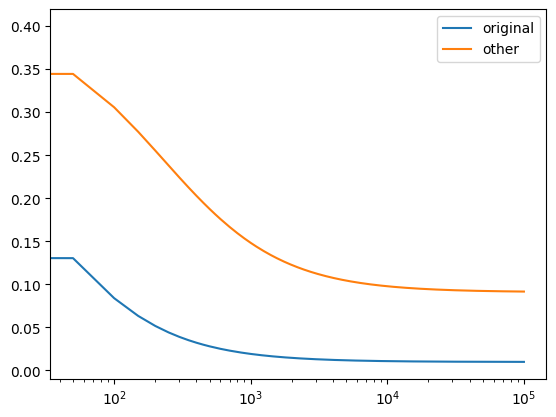

In [71]:
def elkan_optimal_threshold(amount, commission_transaction_gain = 0.01, avg_accept_fraud_cost = 20, avg_refuse_legit_cost = 10):
    c00 = -commission_transaction_gain * amount  # Accepting a legitimate transaction
    c01 = amount + avg_accept_fraud_cost  # Accepting a fraudulent transaction
    c10 = avg_refuse_legit_cost  # Refusing a legitimate transaction
    c11 = 0  # Refusing a fraudulent transaction
    return (c10 - c00) / (c10 - c00 + c01 - c11)

amt = np.linspace(0, 100000, 2000)
plt.plot(amt , elkan_optimal_threshold(amt), label="original")
plt.plot(amt , elkan_optimal_threshold(amt, commission_transaction_gain=0.1, avg_refuse_legit_cost=100, avg_accept_fraud_cost=150), label="other")
plt.xscale("log")
plt.legend()

In [72]:
commission_transaction_gain = 0.1
avg_accept_fraud_cost = 100
avg_refuse_legit_cost = 150

In [61]:
est = LogisticRegression(max_iter=1000, random_state=42)
est.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [60]:
# def optimal_threshold(y_true, y_pred, amount):
#     true_negative = (y_pred == 0) & (y_true == 0)
#     false_negative = (y_pred == 0) & (y_true == 1)
#     false_positive = (y_pred == 1) & (y_true == 0)
#     true_positive = (y_pred == 1) & (y_true == 1)

#     accept_legitimate = (amount[true_negative] * commission_transaction_gain).sum()
#     accept_fraudulent = -(amount[false_negative].sum() + (false_negative * avg_accept_fraud_cost).sum())
#     refuse_legitimate = -(false_positive * avg_refuse_legit_cost).sum()
#     refuse_fraudulent = 0
    
#     return (refuse_legitimate - accept_legitimate) / (refuse_legitimate - refuse_fraudulent + accept_fraudulent - accept_legitimate)


# optimal_threshold(y_train, est.predict(X_train), amount_train)

In [73]:
class VariableThresholdClassifier:
    def __init__(self, classifier, variable_threshold):
        self.classifier = classifier
        self.variable_threshold = variable_threshold

    def fit(self, X, y):
        return self

    def predict(self, X, amount):
        proba = self.classifier.predict_proba(X)[:, 1]
        return (proba >= self.variable_threshold(amount)).astype(np.int32)


business_score = business_gain_func(
    y_test,
    VariableThresholdClassifier(
        est,
        variable_threshold=elkan_optimal_threshold,
    ).predict(X_test, amount=amount_test),
    amount=amount_test,
)
print(
    f"Benefit of logistic regression with optimal variable threshold: "
    f"{business_score:,.2f}€"
)

Benefit of logistic regression with optimal variable threshold: 1,220,881.69€


In [74]:
print(
    f"Benefit of logistic regression: "
    f"{business_gain_func(y_test, est.predict(X_test), amount_test):,.2f}€"
)

Benefit of logistic regression: 1,228,592.60€


In [75]:
from sklearn.model_selection import TunedThresholdClassifierCV

tuned_model = TunedThresholdClassifierCV(
    estimator=est.fit(X_train, y_train),
    scoring=business_gain_scorer,
    thresholds=100,
    n_jobs=-1,
).fit(X_train, y_train, amount=amount_train)

In [76]:
print(
    f"Benefit of logistic regression with tuned threshold: "
    f"{business_gain_func(y_test, tuned_model.predict(X_test), amount_test):,.2f}€"
)

Benefit of logistic regression with tuned threshold: 1,226,998.91€


You probably want to check a bunch of things here. We have not checked for calibration, we also did not check for statistical significance, and we probably want to understand the effect of having a weekend/weekday in here as well. If you want to guess the impact you might also need to do a back of the letter calculation. If this is the amount of money saved per day, then recognising variable thresholds gives you approximately half a million euros a year. 

All of these things are important follow up steps, but they are kind of like details, it is not the main lesson. 

The main lesson here is that the potential of scikit-learn really depends on how well you are able to translate your business problem into an algorithmic one. There is a risk that you think too much in numeric terms and metrics and that you forget about the application. Only when you understand this will you be able to apply scikit-learn effectively. It is an amazing suite of building blocks, but you still need to be an intelligent human in the loop to make sure that it is applied in a sensible way. 

Please grant yourself this creative freedom. Without it, you are missing out. 

Thanks for listening. 